
# Attention & Transformers

**Levels**
1. Attention intuition with a toy example and heatmap
2. Self-attention inside a Transformer encoder (BERT) — visualize attention
3. Attention in action: summarization and a quick Vision Transformer map

## Setup — run once

In [ ]:

# If needed, uncomment to install
# %pip install -q torch torchvision torchaudio transformers matplotlib pillow numpy requests



## Level 1 — *Where should the model look?* (Toy Attention)
Visualize scaled dot-product attention weights for the pronoun **"it"**.


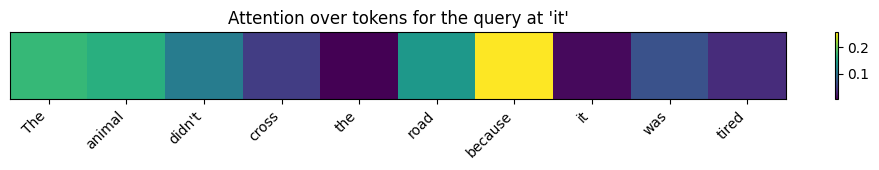

In [1]:

import numpy as np
import matplotlib.pyplot as plt

tokens = ["The","animal","didn't","cross","the","road","because","it","was","tired"]

np.random.seed(0)
d = 4
Q = np.random.randn(1, d)          # query for "it"
K = np.random.randn(len(tokens), d) # keys for all tokens

scale = np.sqrt(d)
scores = (Q @ K.T) / scale
weights = np.exp(scores - scores.max())
weights = weights / weights.sum()

plt.figure(figsize=(10, 1.8))
plt.imshow(weights, aspect="auto")
plt.yticks([])
plt.xticks(range(len(tokens)), tokens, rotation=45, ha="right")
plt.title("Attention over tokens for the query at 'it'")
plt.colorbar()
plt.tight_layout()
plt.show()



### Exercise 1 (2 pts)
Edit the sentence so **"it"** refers to **"road"** (not **"animal"**). Re-run the plot cell and observe attention shift.


In [ ]:

# YOUR TURN: Modify 'tokens' and re-run the plot cell above.
tokens = ["The","animal","didn't","cross","the","road","because","it","was","narrow"]
pass


In [ ]:

# (Graded sanity check 2 pts)
assert isinstance(tokens, list) and all(isinstance(t, str) for t in tokens)



## Level 2 — Self-Attention in BERT (Encoder)
We visualize the last layer's attention for a sentence (downloads model on first run).


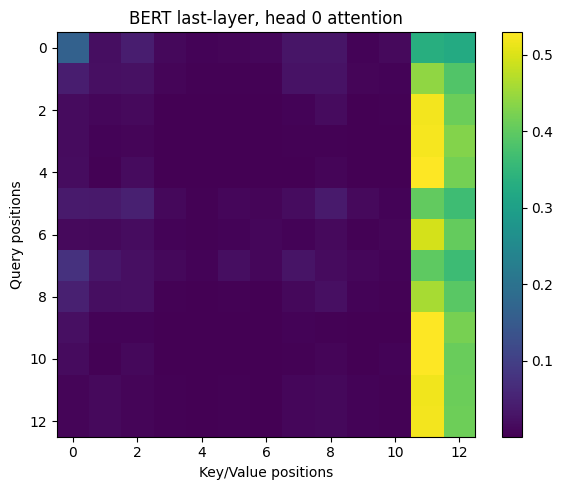

Tokens: ['[CLS]', 'the', 'cat', 'sat', 'on', 'the', 'mat', 'because', 'it', 'was', 'tired', '.', '[SEP]']


In [2]:

import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased", output_attentions=True).to(device)

sentence = "The cat sat on the mat because it was tired."
inputs = tokenizer(sentence, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

attentions = outputs.attentions  # (layers, batch, heads, seq, seq)
last = attentions[-1][0]         # (heads, seq, seq)
head0 = last[0].cpu().numpy()

plt.figure(figsize=(6,5))
plt.imshow(head0, aspect="auto")
plt.title("BERT last-layer, head 0 attention")
plt.xlabel("Key/Value positions")
plt.ylabel("Query positions")
plt.colorbar()
plt.tight_layout()
plt.show()

print("Tokens:", tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))



### Exercise 2 (4 pts)
Change the sentence so **"it"** refers to **"mat"** (not **"cat"**), then re-run the visualization.
Describe what changes in the attention (2–4 sentences) below.


*Your explanation here*

In [3]:

# Auto-check heuristic (4 pts): encourage both 'mat' and 'cat' in sentence.
text = sentence.lower()
score = 0
if "mat" in text: score += 2
if "cat" in text: score += 2
print("Auto-score suggestion (out of 4):", score)


Auto-score suggestion (out of 4): 4



## Level 3 — Applications
### A) Summarization


In [4]:

from transformers import pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
text = (
    "Transformers enable parallel sequence processing through self-attention, capturing long-range "
    "dependencies and benefiting large-scale pretraining. This has led to major improvements in tasks "
    "like machine translation, summarization, and question answering."
)
print(summarizer(text, max_length=40, min_length=15, do_sample=False)[0]['summary_text'])


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Transformers enable parallel sequence processing through self-attention. This has led to major improvements in tasks like machine translation, summarization and question answering.



### B) Vision Transformer — CLS→patch attention map


In [5]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import ViTFeatureExtractor, ViTModel


In [8]:
url = "cat_sample.jpg"
#img = Image.open(BytesIO(requests.get(url).content)).convert("RGB")
img = Image.open(url).convert("RGB")


In [9]:
extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
model = ViTModel.from_pretrained("google/vit-base-patch16-224", output_attentions=True)


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/Users/ashis/venv-directory/venv-p310-torch2/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
inputs = extractor(images=img, return_tensors="pt")
with torch.no_grad():
    out = model(**inputs)


In [11]:
attn = out.attentions[-1][0,0]  # (seq, seq)
cls_to_patches = attn[0,1:].numpy()
side = int(np.sqrt(cls_to_patches.shape[0]))
heat = cls_to_patches.reshape(side, side)


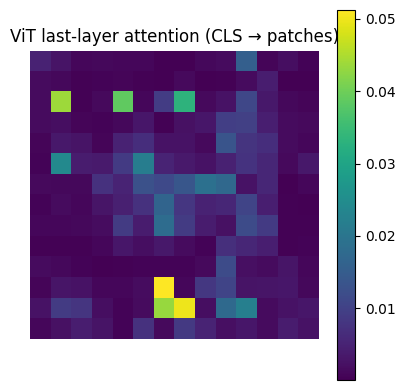

In [12]:
plt.figure(figsize=(4,4))
plt.imshow(heat)
plt.title("ViT last-layer attention (CLS → patches)")
plt.axis("off")
plt.colorbar()
plt.tight_layout()
plt.show()



## Reflection (2 pts)
Explain how attention differs from RNN-style context handling and why transformer parallelism matters (3–5 sentences).


*Your reflection here*